First step:
Check whether the (preprocessed) data that we feed into the script is identical.

Let's load the yaml that sets the parameters for the correlation.

In [138]:
import yaml
import os
os.chdir('/home/pm/Documents/PhD/testdata')
with open('params.yaml') as file:
    di = yaml.load(file, Loader=yaml.FullLoader)
print(di)  # Not all keys are in use, some are just from the old miic implementation
print('\n\nThis is the place, where our preprocessed data is stored: ', os.path.join(di['proj_dir'],di['prepro_subdir']))

{'proj_dir': '/home/pm/Documents/PhD/testdata/', 'log_subdir': 'log', 'fig_subdir': 'figures', 'prepro_subdir': 'testnb_preprocessed_dailypp', 'net': {'network': 'D0', 'station': ['BZG', 'ESO', 'KBG', 'KIR'], 'channels': ['HHZ', 'HHN', 'HHE'], 'coordinate_file': 'coordinates.txt', 'fss': ['/DATA/mseed', '%STA', ['%sta', '%y', '%m', '%d', '??????', '.', '%cha']]}, 'co': {'subdir': 'corr_dailypp', 'read_start': '2015-08-1 00:00:01.0', 'read_end': '2015-08-06 00:00:00.0', 'read_len': 86398, 'read_inc': 86400, 'combination_method': 'betweenStations', 'preProcessing': [{'function': 'miic3.utils.miic_utils.stream_filter', 'args': {'ftype': 'bandpass', 'filter_option': {'freqmin': 2, 'freqmax': 4}}}], 'subdivision': {'corr_inc': 3600, 'corr_len': 3600, 'recombine_subdivision': True, 'delete_subdivision': False}, 'taper': False, 'corr_args': {'TDpreProcessing': [{'function': 'miic3.correlate.correlate.clip', 'args': {'std_factor': 3}}], 'FDpreProcessing': [{'function': 'miic3.correlate.correla

Let's define a slightly altered version of miic3.correlate.correlate.Correlator

In [140]:
from copy import deepcopy
from ctypes import string_at
import os
from time import time

from mpi4py import MPI
import numpy as np
from obspy import Stream, UTCDateTime, Inventory
from obspy.core.util.base import _get_function_from_entry_point
import obspy.signal as osignal
from scipy.fftpack import next_fast_len
from scipy import signal

from miic3.correlate.stream import CorrTrace, CorrStream
from miic3.db.asdf_handler import get_available_stations, NoiseDB
from miic3.db.corr_hdf5 import CorrelationDataBase
from miic3.utils.fetch_func_from_str import func_from_str

from miic3.correlate.correlate import calc_cross_combis, st_to_np_array, zeroPadding, rfftfreq


class Correlator(object):
    """
    Object to manage the actual Correlation (i.e., Green's function retrieval)
    for the database.
    """
    def __init__(self, options: dict) -> None:
        """
        Initiates the Correlator object. When executing
        :func:`~miic3.correlate.correlate.Correlator.pxcorr()`, it will
        actually compute the correlations and save them in an hdf5 file that
        can be handled using :class:`~miic3.db.corr_hdf5.CorrelationDataBase`.
        Data has to be preprocessed before calling this (i.e., the data already
        has to be given in an ASDF format). Consult
        :class:`~miic3.trace_data.preprocess.Preprocessor` for information on
        how to proceed with this.

        :param options: Dictionary containing all options for the correlation.
        :type options: dict
        """
        super().__init__()
        # init MPI
        self.comm = MPI.COMM_WORLD
        self.psize = self.comm.Get_size()
        self.rank = self.comm.Get_rank()
        self.proj_dir = options['proj_dir']
        self.corr_dir = os.path.join(self.proj_dir, options['co']['subdir'])
        os.makedirs(self.corr_dir, exist_ok=True)

        self.options = options['co']

        # find the available noise dbs
        network = options['net']['network']
        station = options['net']['station']
        if isinstance(network, str):
            network = [network]
        if isinstance(station, str):
            station = [station]
        if len(station) != len(network):
            if len(station) == 1:
                station = station*len(network)
            elif len(network) == 1:
                network = network*len(station)
            else:
                raise ValueError("""The lists containing network and station
                codes must either have the same length or one of them can have
                the length 1""")
        # Resolve patterns
        self.netlist = []
        self.statlist = []
        for net, stat in zip(network, station):
            if '*' in network+station or '?' in net+stat:
                net, stat = get_available_stations(
                    os.path.join(self.proj_dir, options['prepro_subdir']),
                    net, stat)
                self.netlist.extend(net)
                self.statlist.extend(stat)
            else:
                self.netlist.append(net)
                self.statlist.append(stat)

        # and, finally, find the hdf5 files associated to each of them
        self.noisedbs = [NoiseDB(
            os.path.join(self.proj_dir, options['prepro_subdir']), net, stat)
            for net, stat in zip(self.netlist, self.statlist)]
        # note that the indexing in the noisedb list and in the statlist
        # are identical, which could be useful to find them easily
        # Check whether all the data has the same sampling rate
        self.sampling_rate = self.noisedbs[0].sampling_rate
        for ndb in self.noisedbs:
            if ndb.sampling_rate != self.sampling_rate:
                raise ValueError(
                    'Station %s.%s has a different sampling rate with %s Hz.\
                The sampling rate taken from station %s.%s is %s Hz.'
                    % (ndb.network, ndb.station, ndb.sampling_rate,
                        self.noisedbs[0].network, self.noisedbs[0].station,
                        self.sampling_rate))

    def pxcorr(self, return_input=False, return_after_TD=False, return_after_fft=False, return_after_FD=False, return_after_corr=False):
        """
        Start the correlation with the parameters that were defined when
        initiating the object.
        """
        # Only for testing purposes. The list in which we will save the comparison matrices
        # Fetch station coordinates
        if self.rank == 0:
            inv = self._get_inventory()
        else:
            inv = None
        inv = self.comm.bcast(inv, root=0)
        for st, write_flag in self._generate_data():
            return self._pxcorr_inner(st, inv, return_input, return_after_TD, return_after_fft, return_after_FD, return_after_corr)
        # It should be enough to only return the first iteration

    def _pxcorr_inner(self, st: Stream, inv: Inventory, return_input, return_after_TD, return_after_fft, return_after_FD, return_after_corr):
        """
        Inner loop of pxcorr. Don't call this function!
        """
            
        # We start out by moving the stream into a matrix
        # Advantage of only doing this on rank 0?
        if self.rank == 0:
            # put all the data into a single stream
            starttime = []
            npts = []
            for tr in st:
                starttime.append(tr.stats['starttime'])
                npts.append(tr.stats['npts'])
            npts = np.max(np.array(npts))
            # create numpy array - Do a QR detrend here?
            A, st = st_to_np_array(st, npts)
            # A = qr_detrend(A)
            # detrend is done earlier now
            As = A.shape
        else:
            starttime = None
            npts = None
            As = None
        # del st  # save some memory
        starttime = self.comm.bcast(starttime, root=0)
        npts = self.comm.bcast(npts, root=0)
        st = self.comm.bcast(st, root=0)

        # Tell the other processes the shape of A
        As = self.comm.bcast(As, root=0)
        if self.rank != 0:
            A = np.empty(As, dtype=np.float32)  # np.float32
        self.comm.Bcast([A, MPI.FLOAT], root=0)  # MPI.FLOAT

        self.options.update(
            {'starttime': starttime,
                'sampling_rate': self.sampling_rate})
        # For testing purposes return the input
        if return_input:
            return A
        A, _ = self._pxcorr_matrix(A, return_after_TD, return_after_fft, return_after_FD, return_after_corr)
        # In this version, we just want the matrix
        return A

    def _get_inventory(self) -> Inventory:
        """
        Returns an :class:`~obspy.core.inventory.Inventory` object containing
        information about all stations that are used for this correlation

        :return: :class:`~obspy.core.inventory.Inventory`
        :rtype: Inventory
        """
        inv = Inventory()
        for ndb in self.noisedbs:
            inv.extend(ndb.get_inventory())
        return inv

    def _generate_data(self) -> Stream:
        """
        Returns an Iterator that loops over each start and end time with the
        requested window length.

        If self.options['taper'] true, the time windows will be tapered on both
        ends.
        Also will lead to the time windows being prolonged by the sum of
        the length of the tapered end, so that no data is lost. Always
        a hann taper so far. Taper length is 5% of the requested time
        window on each side.

        :yield: An obspy stream containing the time window x for all stations
        that were active during this time.
        :rtype: Iterator[Stream]
        """
        opt = self.options['subdivision']
        if self.rank == 0:
            starts = []  # start of each time window
            ends = []
            for ndb in self.noisedbs:
                start, end = ndb.get_active_times()
                starts.append(start)
                ends.append(end)

        # the time window that the loop will go over
        t0 = UTCDateTime(self.options['read_start']).timestamp
        t1 = UTCDateTime(self.options['read_end']).timestamp
        loop_window = np.arange(t0, t1, self.options['read_inc'])


        for t in loop_window:
            write_flag = True  # Write length is same as read length
            if self.rank == 0:
                st = Stream()
                startt = UTCDateTime(t)
                endt = startt + self.options['read_len']
                for ii, ndb in enumerate(self.noisedbs):
                    # Skip if time window is not available for this station
                    # Note that this will return shorter time windows if
                    # the requested time is only partly available
                    if endt < starts[ii] or startt > ends[ii]:
                        continue
                    st.extend(ndb.get_time_window(startt, endt))
                # preprocessing on stream basis
                # Maybe a bad place to do that? 
                # st = st.split()  # remove masked data
                # if 'filter' in self.options['preProcessing'].keys():
                #     kwargs = self.options['preProcessing']['filter']['kwargs']
                #     st.filter(**kwargs)
                # st.merge()  # Else it messes with the indexing
                if 'preProcessing' in self.options.keys():
                    for procStep in self.options['preProcessing']:
                        func = func_from_str(procStep['function'])
                        st = func(st,**procStep['args'])
            else:
                st = None
            st = self.comm.bcast(st, root=0)
            if st.count() == 0:
                # No time available at none of the stations
                continue
            # Second loop to return the time window in correlation length
            for win in st.slide(
                opt['corr_len']-st[0].stats.delta, opt['corr_inc'],
                    include_partial_windows=True):
                if self.options['taper']:
                    # This could be done in the main script with several cores
                    # to speed up things a tiny bit
                    win.taper(max_percentage=0.05)
                self.options['combinations'] = calc_cross_combis(st)
                yield win, write_flag
                write_flag = False

    def _pxcorr_matrix(self, A: np.ndarray, return_after_TD, return_after_fft, return_after_FD, return_after_corr):
        # time domain processing
        # map of traces on processes
        ntrc = A.shape[1]
        pmap = (np.arange(ntrc)*self.psize)/ntrc
        # This step was not in the original but is necessary for it to work?
        # maybe a difference in an old python/np version?
        pmap = pmap.astype(np.int32)

        # indices for traces to be worked on by each process
        ind = pmap == self.rank

    ######################################
        corr_args = self.options['corr_args']
        # time domain pre-processing
        params = {}
        for key in list(corr_args.keys()):
            if 'Processing' not in key:
                params.update({key: corr_args[key]})
        params['sampling_rate'] = self.sampling_rate
        # The steps that aren't done before

        for proc in corr_args['TDpreProcessing']:
            func = func_from_str(proc['function'])
            A[:, ind] = func(A[:, ind], proc['args'], params)
        if return_after_TD:
            return A, None

        # zero-padding
        A = zeroPadding(A, {'type': 'avoidWrapPowerTwo'}, params)

        ######################################
        # FFT
        # Allocate space for rfft of data
        zmsize = A.shape
        fftsize = zmsize[0]//2+1
        B = np.zeros((fftsize, ntrc), dtype=complex)

        B[:, ind] = np.fft.rfft(A[:, ind], axis=0)

        freqs = rfftfreq(zmsize[0], 1./self.sampling_rate)

        if return_after_fft:
            return B, None

        ######################################
        # frequency domain pre-processing
        params.update({'freqs': freqs})
        # Here, I will have to make sure to add all the functions to the module
        for proc in corr_args['FDpreProcessing']:

            # The big advantage of this rather lengthy code is that we can also
            # import any function that has been defined anywhere else (i.e,
            # not only within the miic framework)
            func = func_from_str(proc['function'])
            B[:, ind] = func(B[:, ind], proc['args'], params)

        ######################################
        # collect results
        self.comm.barrier()
        self.comm.Allreduce(MPI.IN_PLACE, [B, MPI.DOUBLE], op=MPI.SUM)

        if return_after_FD:
            return B, None

        ######################################
        # correlation
        csize = len(self.options['combinations'])
        irfftsize = (fftsize-1)*2
        sampleToSave = int(
            np.ceil(
                corr_args['lengthToSave'] * self.sampling_rate))
        C = np.zeros((sampleToSave*2+1, csize), dtype=np.float64)

        # center = irfftsize // 2
        pmap = (np.arange(csize)*self.psize)/csize
        pmap = pmap.astype(np.int32)
        ind = pmap == self.rank
        ind = np.arange(csize)[ind]
        startlags = np.zeros(csize, dtype=np.float64)
        if return_after_corr:
            return_list = []
        for ii in ind:
            # offset of starttimes in samples(just remove fractions of samples)
            offset = (
                self.options['starttime'][
                    self.options['combinations'][ii][0]] - self.options[
                        'starttime'][self.options['combinations'][ii][1]])
            if corr_args['center_correlation']:
                roffset = 0.
            else:
                # offset exceeding a fraction of integer
                roffset = np.fix(
                    offset * self.sampling_rate) / self.sampling_rate
            # faction of samples to be compenasated by shifting
            offset -= roffset
            # normalization factor of fft correlation
            if corr_args['normalize_correlation']:
                norm = (
                    np.sqrt(
                        2.*np.sum(B[:, self.options[
                            'combinations'][ii][0]] *
                            B[:, self.options['combinations'][ii][0]].conj()) -
                        B[0, self.options['combinations'][ii][0]]**2) *
                    np.sqrt(
                        2.*np.sum(B[:, self.options[
                            'combinations'][ii][1]] *
                            B[:, self.options['combinations'][ii][1]].conj()) -
                        B[0, self.options['combinations'][ii][1]]**2) /
                    irfftsize).real
            else:
                norm = 1.
            M = (
                B[:, self.options['combinations'][ii][0]].conj() *
                B[:, self.options['combinations'][ii][1]] *
                np.exp(1j * freqs * offset * 2 * np.pi))
            
            if return_after_corr:
                return_list.append(M)

            ######################################
            # frequency domain postProcessing
            #

            tmp = np.fft.irfft(M, axis=0).real

            # cut the center and do fftshift
            C[:, ii] = np.concatenate(
                (tmp[-sampleToSave:], tmp[:sampleToSave+1]))/norm
            startlags[ii] = - sampleToSave / self.sampling_rate \
                - roffset

        if return_after_corr:
            return(np.array(return_list)), None
        ######################################
        # time domain postProcessing

        ######################################
        # collect results
        self.comm.barrier()
        self.comm.Allreduce(MPI.IN_PLACE, [C, MPI.DOUBLE], op=MPI.SUM)
        self.comm.Allreduce(MPI.IN_PLACE, [startlags, MPI.DOUBLE], op=MPI.SUM)
        return (C, startlags)

## 1. Compare the matrices after downsampling (from 100 to 25 Hz) and bandpass filter (as given in the key PreProcessing)
**Note:** in this case, the decimating/downsampling for the new miic has been done on daily streams

In [142]:
c = Correlator(di)
A = c.pxcorr(return_input=True)

(90000, 12)
(90000, 12)


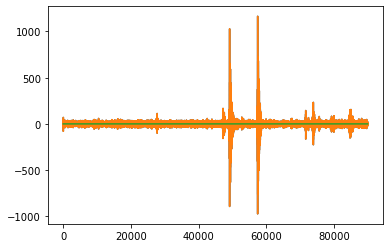

In [144]:
# Load the same from miic2
import numpy as np
A_old = np.load('/home/pm/Documents/PhD/testdata/input_old.npy')

from matplotlib import pyplot as plt
#plt.plot(A_old-A)
plt.plot(A_old[:,2])
# Note that the components are sorted differently
plt.plot(A[:,0])
plt.plot(A[:,0]-A_old[:,2])
print(A.shape)
print(A_old.shape)

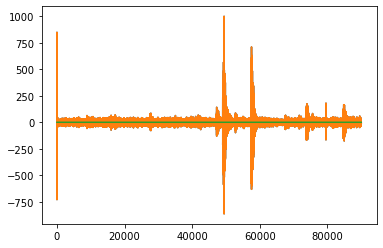

In [146]:
# Check for another component, just to be safe
plt.plot(A_old[:,0])
# Note that the components are sorted differently
plt.plot(A[:,2])
plt.plot(A[:,2]-A_old[:,0])

## 2. Compare the matrices after TDPreprocessing

In [148]:
B = c.pxcorr(return_after_TD=True)

(90000, 12)
(90000, 12)


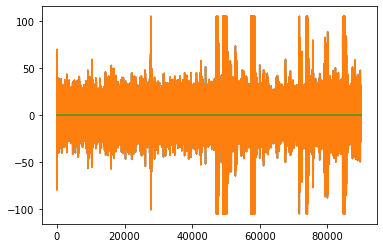

In [150]:
# Load the same from miic2
import numpy as np
B_old = np.load('/home/pm/Documents/PhD/testdata/afterTD_old.npy')

from matplotlib import pyplot as plt
plt.plot(B_old[:,2])
# Note that the components are sorted differently
plt.plot(B[:,0])
plt.plot(B[:,0]-B_old[:,2])
print(B.shape)
print(B_old.shape)

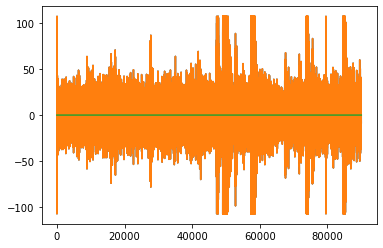

In [152]:
# Check for another component, just to be safe
plt.plot(B_old[:,0])
# Note that the components are sorted differently
plt.plot(B[:,2])
plt.plot(B[:,2]-B_old[:,0])

Ok that seems to work so next step

## 3. Compare Matrices after the fft

In [154]:
C = c.pxcorr(return_after_fft=True)

(46657, 12)
(46657, 12)
/home/pm/miniforge3/envs/miic3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/pm/miniforge3/envs/miic3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/pm/miniforge3/envs/miic3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


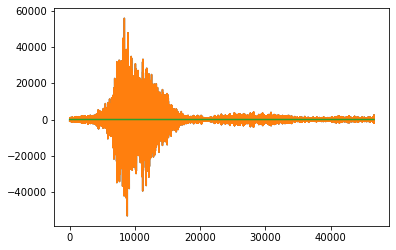

In [156]:
# Load the same from miic2
import numpy as np
C_old = np.load('/home/pm/Documents/PhD/testdata/afterfft_old.npy')

from matplotlib import pyplot as plt
plt.plot(C_old[:,2])
# Note that the components are sorted differently
plt.plot(C[:,0])
plt.plot(C[:,0]-C_old[:,2])
print(C.shape)
print(C_old.shape)

/home/pm/miniforge3/envs/miic3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/pm/miniforge3/envs/miic3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/pm/miniforge3/envs/miic3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


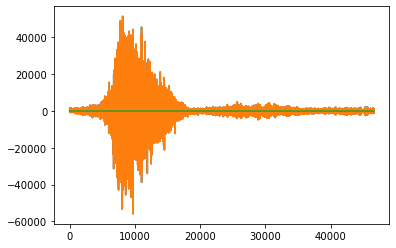

In [158]:
# Check for another component, just to be safe
plt.plot(C_old[:,0])
# Note that the components are sorted differently
plt.plot(C[:,2])
plt.plot(C[:,2]-C_old[:,0])

Again, looks pretty good

## 4. Compare Matrices after FDpreprocessing

In [160]:
D = c.pxcorr(return_after_FD=True)

/home/pm/miniforge3/envs/miic3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/pm/miniforge3/envs/miic3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/pm/miniforge3/envs/miic3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/pm/miniforge3/envs/miic3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/pm/miniforge3/envs/miic3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imagi

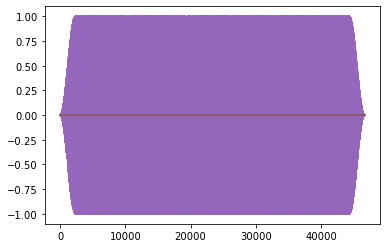

In [162]:
# Load the same from miic2
import numpy as np
D_old = np.load('/home/pm/Documents/PhD/testdata/afterFD_old.npy')

from matplotlib import pyplot as plt
plt.plot(D_old[:,2])
# Note that the components are sorted differently
plt.plot(D[:,0])
plt.plot(D[:,0]-D_old[:,2])# Load the same from miic2
import numpy as np
D_old = np.load('/home/pm/Documents/PhD/testdata/afterFD_old.npy')

from matplotlib import pyplot as plt
plt.plot(D_old[:,2])
# Note that the components are sorted differently
plt.plot(D[:,0])
plt.plot(D[:,0]-D_old[:,2])
print(D.shape)
print(D_old.shape)
print(D.shape)
print(D_old.shape)

/home/pm/miniforge3/envs/miic3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/pm/miniforge3/envs/miic3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/pm/miniforge3/envs/miic3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


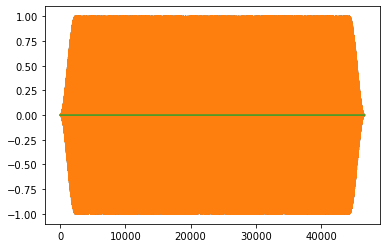

In [164]:
# Check for another component, just to be safe
plt.plot(D_old[:,0])
# Note that the components are sorted differently
plt.plot(D[:,2])
plt.plot(D[:,2]-D_old[:,0])

Ok, still everything in order. Let's have a look at the correlation results in frequency domain

## 5. After Correlation (FD)
difficult as the order is different. Let's skip over this now and see whether the next one is still alright

In [166]:
E = c.pxcorr(return_after_corr=True)

(54, 46657)
(46657,)
23.0
24.0
/home/pm/miniforge3/envs/miic3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


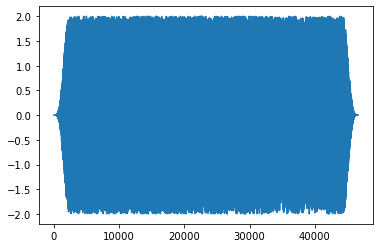

In [168]:
# Load the same from miic2
import numpy as np
E_old = np.load('/home/pm/Documents/PhD/testdata/aftercorr_old.npy')
print(E.shape)
print(E_old.shape)
# given that E is complex, it should be ok to compare the real and imaginary values seperately
print(np.median(np.argmin(E.real-E_old.real.T, axis=0)))
print(np.median(np.argmin(E.imag-E_old.imag.T, axis=0)))
from matplotlib import pyplot as plt
#plt.plot(E_old)
# Note that the components are sorted differently
#plt.plot(E[23,])
plt.plot(E[2,]-E_old)


Ok, something is definitely wrong here. Maybe I am changing dimensions. Kinda fishy that the station combinations are suddenly on the lines and time on the columns.

Maybe I should also check the combinations dictionary?

## 5.1. Compare the combination dictionaries

In [173]:
import yaml
with open('combinations.yml') as file:
    combinations_old = yaml.load(file, Loader=yaml.FullLoader)
c.pxcorr()
combinations = c.options["combinations"]

In [174]:
print(combinations==combinations_old)
print(combinations)
print(combinations_old)
# Essentially they are the same just in a different order

False
[(0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (3, 6), (3, 7), (3, 8), (3, 9), (3, 10), (3, 11), (4, 6), (4, 7), (4, 8), (4, 9), (4, 10), (4, 11), (5, 6), (5, 7), (5, 8), (5, 9), (5, 10), (5, 11), (6, 9), (6, 10), (6, 11), (7, 9), (7, 10), (7, 11), (8, 9), (8, 10), (8, 11)]
[(0, 4), (0, 5), (0, 3), (0, 6), (0, 7), (0, 8), (0, 9), (0, 11), (0, 10), (1, 4), (1, 5), (1, 3), (1, 6), (1, 7), (1, 8), (1, 9), (1, 11), (1, 10), (2, 4), (2, 5), (2, 3), (2, 6), (2, 7), (2, 8), (2, 9), (2, 11), (2, 10), (3, 6), (3, 7), (3, 8), (3, 9), (3, 11), (3, 10), (4, 6), (4, 7), (4, 8), (4, 9), (4, 11), (4, 10), (5, 6), (5, 7), (5, 8), (5, 9), (5, 11), (5, 10), (6, 9), (6, 11), (6, 10), (7, 9), (7, 11), (7, 10), (8, 9), (8, 11), (8, 10)]


In [191]:
# We can confirm that by just testing the two functions
from miic3.correlate.correlate import calc_cross_combis
from obspy import read, Stream
st = read()
st.extend(read('/home/pm/Documents/PhD/testdata/2015/D0/BDR/SHE.D/D0.BDR.01.SHE.D.2015.213'))
st.extend(read('/home/pm/Documents/PhD/testdata/2015/D0/BZG/HHE.D/D0.BZG.00.HHE.D.2015.213'))

calc_cross_combis(st)

[(0, 3),
 (0, 4),
 (0, 5),
 (0, 6),
 (0, 7),
 (0, 8),
 (1, 3),
 (1, 4),
 (1, 5),
 (1, 6),
 (1, 7),
 (1, 8),
 (2, 3),
 (2, 4),
 (2, 5),
 (2, 6),
 (2, 7),
 (2, 8),
 (3, 7),
 (3, 8),
 (4, 7),
 (4, 8),
 (5, 7),
 (5, 8),
 (6, 7),
 (6, 8)]

In [1]:
# This has to be executed in the old python2 environment
# We can confirm that by just testing the two functions
from miic.core.pxcorr_func import calc_cross_combis
from obspy import read, Stream
st = read()
st.extend(read('/home/pm/Documents/PhD/testdata/2015/D0/BDR/SHE.D/D0.BDR.01.SHE.D.2015.213'))
st.extend(read('/home/pm/Documents/PhD/testdata/2015/D0/BZG/HHE.D/D0.BZG.00.HHE.D.2015.213'))

calc_cross_combis(st)

[(0, 3),
 (0, 4),
 (0, 5),
 (0, 6),
 (0, 7),
 (0, 8),
 (1, 3),
 (1, 4),
 (1, 5),
 (1, 6),
 (1, 7),
 (1, 8),
 (2, 3),
 (2, 4),
 (2, 5),
 (2, 6),
 (2, 7),
 (2, 8),
 (3, 7),
 (3, 8),
 (4, 7),
 (4, 8),
 (5, 7),
 (5, 8),
 (6, 7),
 (6, 8)]

Alright so it's not those functions

## 6. Compare Final result (in matrix form)

In [169]:
F = c.pxcorr()

(5001, 54)
(5001,)
22.0


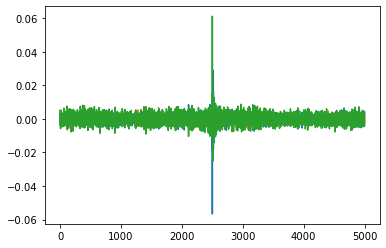

In [170]:
# Load the same from miic2
import numpy as np
F_old = np.load('/home/pm/Documents/PhD/testdata/out_old.npy')
print(F.shape)
print(F_old.shape)
from matplotlib import pyplot as plt
plt.plot(F_old)
# Note that the components are sorted differently
plt.plot(F[:,2])
plt.plot(F[:,2]-F_old)
# just make sure the positions in the matrix did not change
print(np.median(np.argmin(F.T-F_old.T, axis=0)))
#plt.plot(F[:,22])

Looks like we found the culprint!